In [54]:
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [55]:
# import dataset 
data = np.loadtxt(open('mnist_train_small.csv', 'rb'), delimiter=',')
# extract labels (number ID's) and remove from data
labels = data[:,0]
data = data[:,1:]


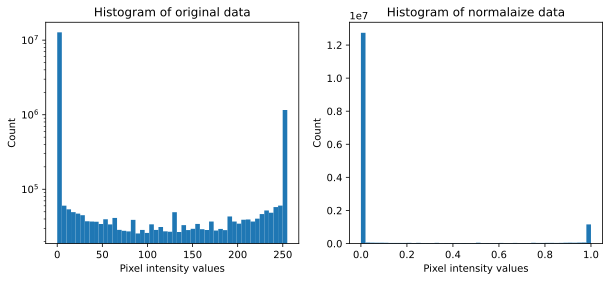

In [56]:
# normalaize the data to a range of [0 1]
dataNorm = data / np.max(data)
 
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_title("Histogram of original data")
ax[0].set_xlabel("Pixel intensity values")
ax[0].set_ylabel("Count")
# not visible in linear because of zero dominance
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_title("Histogram of normalaize data")
ax[1].set_xlabel("Pixel intensity values")
ax[1].set_ylabel("Count")

plt.show()

### Creating train/test sets

In [57]:
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long() # long = int64

train_data,test_data,train_labels, test_labels= train_test_split(dataT, labelsT,test_size=0.1)
 
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)
 
batchSize = 32
train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=True,drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [58]:
# check all variables in workspace
%whos

Variable                        Type             Data/Info
----------------------------------------------------------
DataLoader                      type             <class 'torch.utils.data.dataloader.DataLoader'>
F                               module           <module 'torch.nn.functio<...>orch\\nn\\functional.py'>
TensorDataset                   type             <class 'torch.utils.data.dataset.TensorDataset'>
X                               Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
ax                              ndarray          2: 2 elems, type `object`, 16 bytes
batchSize                       int              32
createTheMNISTNet               function         <function createTheMNISTN<...>et at 0x0000029106DCCCC0>
data                            ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm                        ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes 

## Create the DL model

In [59]:
def createTheMNISTNet():
    
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            
            ### input layer
            self.input = nn.Linear(784,64)
            
            ### hidden layer
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            
            self.output =  nn.Linear(32,10)
            
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return torch.log_softmax(self.output(x),dim=1)
            
    net = Net()
    
    lossFn = nn.NLLLoss()
    
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    
    return net,lossFn,optimizer

In [60]:
# test the model with one batch
net,lossFn,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

#  values are log-probability of each number (0-9)
print(yHat)

# now let's compute the loss
loss = lossFn(yHat,y)
print(" ")
print("Loss:")
print(loss)

tensor([[-2.3945, -2.3551, -2.3200, -2.2012, -2.1914, -2.1724, -2.3106, -2.4792,
         -2.4034, -2.2455],
        [-2.3959, -2.3569, -2.3298, -2.1990, -2.1984, -2.1845, -2.2946, -2.4759,
         -2.4088, -2.2290],
        [-2.3948, -2.3630, -2.3263, -2.1933, -2.1973, -2.1783, -2.3132, -2.4732,
         -2.3980, -2.2351],
        [-2.3952, -2.3591, -2.3224, -2.1997, -2.2049, -2.1847, -2.2909, -2.4753,
         -2.4088, -2.2307],
        [-2.3976, -2.3737, -2.3362, -2.1949, -2.2024, -2.1796, -2.3008, -2.4608,
         -2.3981, -2.2273],
        [-2.3947, -2.3545, -2.3226, -2.2017, -2.1909, -2.1704, -2.3177, -2.4773,
         -2.3988, -2.2445],
        [-2.3942, -2.3582, -2.3292, -2.1990, -2.1976, -2.1794, -2.3038, -2.4773,
         -2.4043, -2.2300],
        [-2.3921, -2.3615, -2.3244, -2.2019, -2.1906, -2.1757, -2.3029, -2.4723,
         -2.4088, -2.2426],
        [-2.3910, -2.3743, -2.3290, -2.1968, -2.1914, -2.1823, -2.3052, -2.4571,
         -2.4005, -2.2425],
        [-2.3902, -

In [61]:
def funcToTrainModel():
    
    num_epochs = 60
    
    net,lossFn,optimizer = createTheMNISTNet()
    
    losses = torch.zeros(num_epochs)
    trainAcc = []
    testAcc = []
    
    for epochI in range(num_epochs):
        
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            
            yHat = net(X)
            loss = lossFn(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            # compute acc
            matches = torch.argmax(yHat,dim=1) == y
            matchesNumeric = matches.float()
            accPct = 100*torch.mean(matchesNumeric)
            batchAcc.append(accPct)
            
        trainAcc.append( np.mean(batchAcc) )
        
        losses[epochI] = np.mean(batchLoss)
        
        X,y = next(iter(test_loader))
        yHat = net(X)
        
        
        testAcc.append( 100*torch.mean((torch.argmax(yHat,dim=1) == y).float()) )
        
    
    return trainAcc,testAcc,losses,net

### Run model

In [62]:
trainAcc,testAcc,losses,net=funcToTrainModel()

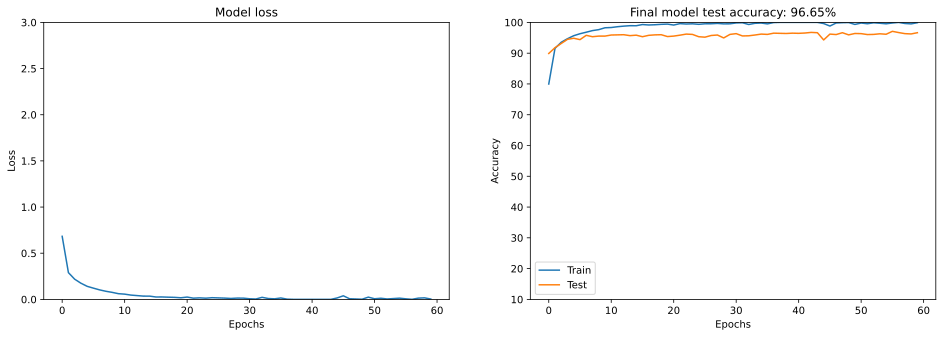

In [63]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title("Model loss")

ax[1].plot(trainAcc,label="Train")
ax[1].plot(testAcc,label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()
plt.show()

### Inspect result in more detail

In [64]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-3.5927e+01,  0.0000e+00, -3.0449e+01,  ..., -2.3956e+01,
         -1.8851e+01, -2.8781e+01],
        [-5.4871e+01,  0.0000e+00, -4.6389e+01,  ..., -3.2765e+01,
         -2.1552e+01, -5.6378e+01],
        [-6.4309e+01, -5.6208e+01,  0.0000e+00,  ..., -3.6076e+01,
         -4.2539e+01, -5.5528e+01],
        ...,
        [-7.4626e+00, -2.4166e+01, -1.9061e+01,  ..., -1.8263e+01,
         -8.8872e-02, -2.4715e+00],
        [-2.3277e+01, -2.5987e-05, -1.1239e+01,  ..., -1.9163e+01,
         -1.2248e+01, -3.2010e+01],
        [-1.9649e+01, -1.5405e+01, -1.7760e+01,  ..., -3.5566e+01,
         -2.7645e+01, -4.7261e+01]])

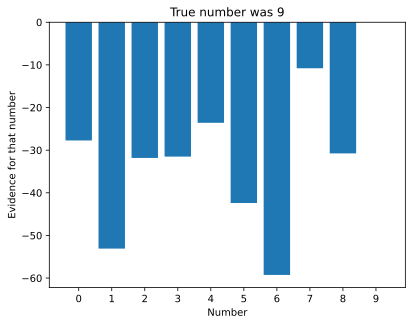

In [65]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[   4   38   41   50   63   80  119  140  158  274  275  314  329  333
  402  409  436  485  514  577  583  614  666  700  720  734  742  748
  753  831  839  864  905  954  979  983 1013 1026 1051 1132 1150 1158
 1206 1243 1245 1272 1274 1363 1378 1401 1425 1605 1668 1676 1689 1759
 1791 1796 1802 1806 1816 1832 1905 1908 1960 1972 1997]


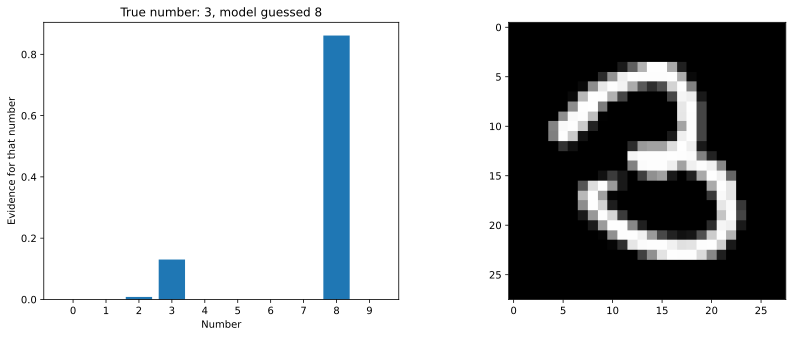

In [69]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 20

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()